*AGEC 652 - Spring 2023*

*Unit 5 - Numerical Optimization*

## Non-homothetic household consumption of water and electricity

## Agenda
In this exercise, we will:
1. Use constrained optimization to solve a household's problem of allocating income to water and electricity with a Stone-Geary utility function
2. Apply the solution structure to generate synthetic data
3. Use unconstrained optimization (Maximum Likelihood) to estimate how expenditure shares in utilities vary with income

## Packages
Start by importing the packages we will need

In [1]:
# To generate data
using Random, Distributions 
# For optimization
using JuMP, Ipopt, Optim 
# Utils for calculations and plotting
using ForwardDiff, LinearAlgebra, Plots, LaTeXStrings


(process:9312): GLib-GIO-WARNING **: 20:47:17.527: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_16.5.1.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


## 0. Setup
Households decide their consumption bundles of water ($w$), electricity ($r$), and other consumption ($x$) following a Stone-Geary utility function
$$U(w, r, x) =  (w - \gamma_w)^{\beta_w}(r - \gamma_r)^{\beta_r}x^{1-\beta_w-\beta_r}$$
where $\gamma_w$ and $\gamma_r$ are the the minimum consumption necessary for household survival, and $\beta$s are model parameters. In this problem, $\beta_w = 0.03$ and $\beta_r = 0.07$

Households maximize utility given their income $y$ subject to budget constraint
$$ y \geq w p_w + r p_w + x $$
where $p_w$ and $p_r$ are water and electricity prices (the price of other consumption is normalized to 1)

## Setup: Prices and units
The average water rate is \\$0.0125 per gallon and electricity rate is \$0.12 per kWh

But remember scale matters! So we need to represent consumptions with appropriately scaled units

- Income: $y$ in thousands of dollars/year
- Water: $w$ in *ten thousands of gallons/year*, $p_w = 0.125$ in *thousand dollars/ten thousand gallons*
- Electricity: $r$ in *GWh/year*, $p_r = 0.12$ in *thousand dollars/GWh*

In [2]:
mean_p_w = 0.125;
mean_p_r = 0.120;

## Setup: Mimimum consumption
- Electricity: typically, 20 gallons per person per day
  - 0.73 ten thousand gallons/year
- Electricity: typically, 10 kWh per person per day
  - 3.65 GWh/year

In [3]:
mean_γ_w = 0.73;
mean_γ_r = 3.65;

## Setup: Income distribution
Income distributions generally assume a log-normal shape. For this example, mean household income is $60$ thousand dollars/year, with a log-standard deviation of 1.5

We will generate a synthetic distribution with $N=300$ households

In [4]:
Random.seed!(65200) # Set a random seed
N = 300;
ys = rand(LogNormal(log(60), log(1.5)), N);

Households have a extra earnings/expenditure shocks that we assumed will be unobserved later on. This is a mean-zero, normally distributed shock

In [5]:
ϵs = rand(Normal(0, 5.0), N);

## Setup: Income distribution
Let's take a look at this distribution

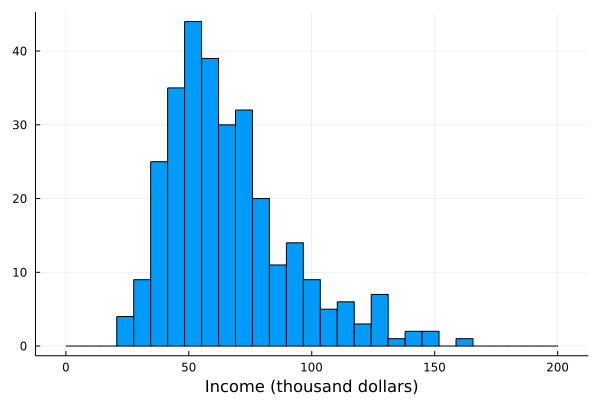

In [6]:
Plots.histogram(ys, bins=range(0, maximum(ys), length = 30),
    label = "", xlabel = "Income (thousand dollars)")

## Setup: Income distribution
We can also check observed vs. actual household income

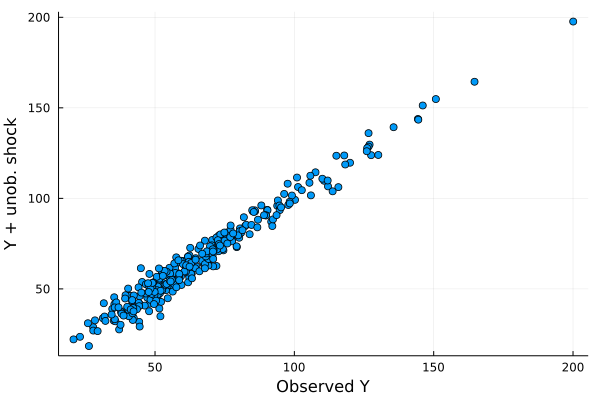

In [7]:
scatter(ys, ys + ϵs, label="",
    xlabel="Observed Y", ylabel="Y + unob. shock")

## Setup: $\gamma$ distributions
Households have different characteristics randomly distributed that affect minimum consumption of water and electricity

We assume these are distributed normally, but truncate the distribuion to avoid it negative or too low $\gamma$s

In [8]:
# Normal truncated below at 0.1, SD is 0.3
γ_ws = rand(TruncatedNormal(mean_γ_w, 0.3, 0.1, Inf), N); 

# Normal truncated below at 0.5, SD is 1.0
γ_rs = rand(TruncatedNormal(mean_γ_r, 1.0, 0.5, Inf), N); 

## Setup: $\gamma$ distributions

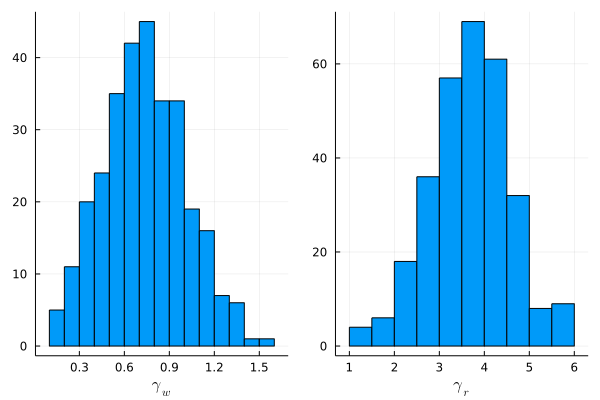

In [9]:
p1 = Plots.histogram(γ_ws,
    label="", xlabel=L"\gamma_w");
p2 = Plots.histogram(γ_rs,
    label="", xlabel=L"\gamma_r");
plot(p1, p2)

## Setup: Price distributions
Households are from different regions in the country and face different prices. Prices are normally distributed around the means previously defined

In [10]:
p_ws = rand(Normal(mean_p_w, 0.02), N);
p_rs = rand(Normal(mean_p_r, 0.02), N);

## Setup: Price distributions

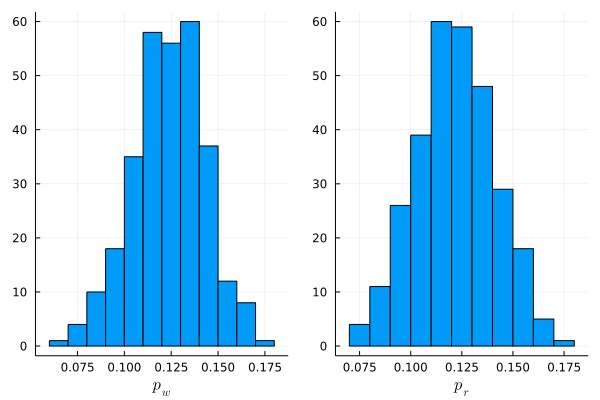

In [11]:
p1 = Plots.histogram(p_ws,
    label="", xlabel=L"p_w");
p2 = Plots.histogram(p_rs,
    label="", xlabel=L"p_r");
plot(p1, p2)

## 1. Optimization: Household utility maximization
We will start with a proof of concept: let's solve the problem for household $i=1$ only

The problem is
$$\max_{w_i, r_i, x_i} U(w_i, r_i, x_i) =  (w_i - \gamma_{w,i})^{\beta_w}(r_i - \gamma_{r,i})^{\beta_r}x_i^{1-\beta_w-\beta_r}$$
subject to $ (y_i + \epsilon_i) \geq w_i p_{w,i} + r_i p_{w_i}+ x_i$

With $\beta_w = 0.03$ and $\beta_r = 0.07$

It's useful to start by defining the fixed parameters ($\beta$s) and the utility function

In [12]:
β_w = 0.03;
β_r = 0.07;
U(w, γ_w, r, γ_r, x) = (w - γ_w)^β_w * (r - γ_r)^β_r * x^(1-β_w-β_r);

## Optimization: Your turn
Using `JuMP` + `Ipopt`, solve the constrained optimization problem for household 1
- Don't forget to account for unobserved earnings: $y_i + \epsilon_i$
- Access household parameters with `ys[1]`, `ϵs[1]`, `γ_ws[1]`, `p_ws[1]`, `γ_rs[1]`, `p_rs[1]`
- This is a nonlinear problem: don't forget to use `@NLobjective` and `@NLconstraint`
- Consult the slides from last class to follow the steps

If you are running into domain problems (fractional exponent of negative numbers), you can set initial values for `Ipopt` with the following

- `set_optimizer_attribute(model, "warm_start_init_point", "yes")`
- `set_start_value(w, γ_ws[1] + 1.0)`
- `set_start_value(r, γ_rs[1] + 1.0)`
- `set_start_value(x, 1.0)`

## Optimization: household 1
We start by declaring the model and it's variables. I will leave $w$ and $r$ as free variables for now (more on it soon)

In [13]:
model = Model(Ipopt.Optimizer);
@variable(model, w);
@variable(model, r);
@variable(model, x >= 0.0);

Since we will solve this model multiple times but with different parameters, we can make use of a `JuMP` feature that allows us to reuse the model: `@NLparameter`

Here is how to use it while declaring your model

In [14]:
@NLparameter(model, y == ys[1] + ϵs[1]);
@NLparameter(model, γ_w == γ_ws[1]);
@NLparameter(model, γ_r == γ_rs[1]);
@NLparameter(model, p_w == p_ws[1]);
@NLparameter(model, p_r == p_rs[1]);

Later on, when we want to resolve the model for another household, we can reassign parameter values with

In [15]:
i = 1;
set_value(y, ys[i] +  ϵs[i]);

Declare the objective and constraints. Now, we can add constraints on $w$ and $r$ using their respective $\gamma$ parameters

In [16]:
@NLobjective(model, Max, U(w, γ_w, r, γ_r, x));
@NLconstraint(model, w >= γ_w);
@NLconstraint(model, r >= γ_r);
@NLconstraint(model, y >= p_w * w + p_r * r + x);

┌ Warning: Function U automatically registered with 5 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :U, 5, U; autodiff = true)
│ ```
└ @ JuMP C:\Users\Diego\.julia\packages\JuMP\zn6NT\src\parse_nlp.jl:21


Checking our model

In [17]:
print(model)

Set initial guesses to avoid domain problems and solve it

In [18]:
set_start_value(w, γ_ws[i] + 1.0);
set_start_value(r, γ_rs[i] + 1.0);
set_start_value(x, 1.0);
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        3
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

Checking the solution

In [19]:
termination_status(model)

LOCALLY_SOLVED::TerminationStatusCode = 4

In [20]:
sol1 = [value(w) , value(r) , value(x)];
sol1'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 14.0726  28.4912  43.533

Expenditure shares

In [21]:
(sol1 .* [p_ws[1], p_rs[1], 1.0] ./ (ys[1] + ϵs[1]))'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.0319371  0.0790014  0.889062

## 2. Data generation: solving all household problems
Next, we will use the model we initialized and solve the problem for each of the 300 households and store the results in vectors

Start by initializing these vectors

In [22]:
ws = zeros(N);
rs = zeros(N);
xs = zeros(N);

It's a good idea to mute the solver

In [23]:
set_silent(model);

## Data generation: your turn
Solve the problem for each of the households and store the solutions in the corresponding vectors
- You can (and should) re-use the model from the first part and change the household-specific parameters before solving it

## Data generation: solving all household problems

We can write a for loop to solve problems in sequence. It's a good practice check the termination statuses as we go

In [24]:
solved_problems = 0;
for i in 1:N
    # Set household-specific parameters
    set_value(y, ys[i] + ϵs[i])
    set_value(γ_w, γ_ws[i])
    set_value(γ_r, γ_rs[i])
    set_value(p_w, p_ws[i])
    set_value(p_r, p_rs[i])    
    # Set initial guesses
    set_start_value(w, γ_ws[i] + 1.0)
    set_start_value(r, γ_rs[i] + 1.0)
    set_start_value(x, 1.0)
    # Solve and store
    optimize!(model)
    ws[i] = value(w)
    rs[i] = value(r)
    xs[i] = value(x)
    if (termination_status(model) == LOCALLY_SOLVED)
        solved_problems += 1
    else
        println("Problem with household $i")
        print(termination_status(model))
    end
end

Check if all problems were locally solved

In [25]:
solved_problems

300

We can examine the relation between consumptions and observed income

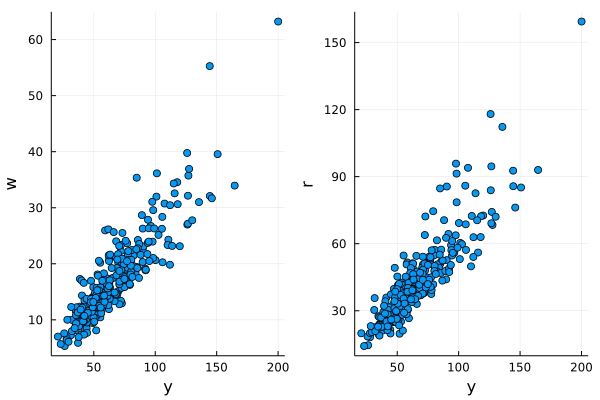

In [26]:
p1 = scatter(ys, ws, label="", xlabel="y", ylabel="w");
p2 = scatter(ys, rs, label="", xlabel="y", ylabel="r");
plot(p1, p2)

## 3. Unconstrained optimization: parameter estimation

We now use the synthetic data we generated based on optimizing behavior and estimate how expenditures in water and electricity respond to changes in income

Start by calculating expenditures

In [27]:
e_ws = ws .* p_ws;
e_rs = rs .* p_rs;

Let's plot expenditures vs. observed income

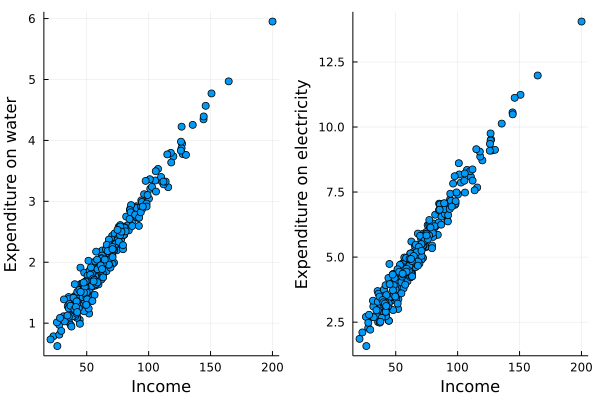

In [28]:
p1 = scatter(ys, e_ws, label="", xlabel="Income", ylabel="Expenditure on water");
p2 = scatter(ys, e_rs, label="", xlabel="Income", ylabel="Expenditure on electricity");
plot(p1, p2)

We can plot expenditure shares vs. actual income and confirm the non-homothetic feature of these preferences

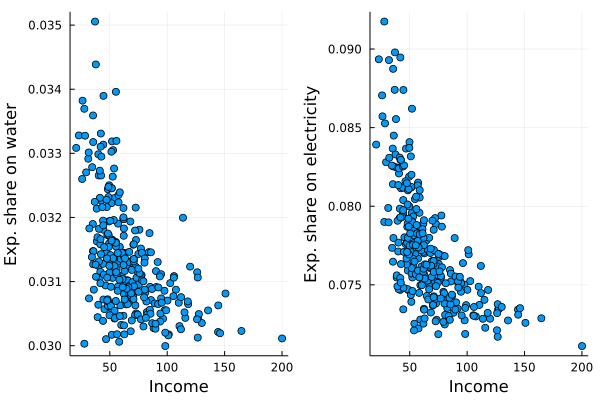

In [29]:
p1 = scatter(ys, e_ws./(ys+ϵs), label="", xlabel="Income", ylabel="Exp. share on water");
p2 = scatter(ys, e_rs./(ys+ϵs), label="", xlabel="Income", ylabel="Exp. share on electricity");
plot(p1, p2)

## Estimation: empirical model
We are interested in estimating $\frac{\partial (w p_w)}{\partial y}$ and $\frac{\partial (r p_r)}{\partial y}$

From the previous graphs, we have an indication that there is a linear relation between expenditures and income, with some dispersion. Thus, we formulate the empirical models
$$w_i p_{w,i} = \alpha_{0,w} + \alpha_{1,w} y_i + \nu_{w,i} \\
r_i p_{r,i} = \alpha_{0,r} + \alpha_{1,r} y_i + \nu_{r,i}$$
where $\nu_{w,i} \sim N(0, \sigma_w^2)$ and $\nu_{r,i} \sim N(0, \sigma_r^2)$. $\sigma_w$ and $\sigma_r$ are unknown

- We need to estimate parameters $\theta = [\alpha_0, \alpha_1, \sigma]$ for each equation

## Estimation: maximum likelihood estimator
We will estimate those parameters using the Maximum Likelihood Estimator

From the empirical model, we can write
$$\nu_w|X_w \sim N(0, \sigma_w^2) \Rightarrow (Y_w - X_w\alpha_w) | X_w \sim N(0, \sigma_w^2)$$
where $Y_w$ is a $N$-vector of expenditures on water, $X_w$ is a $N\times 2$ matrix with ones in the first column and income in the second

For a specific observation $i$, the density of the error term is $\phi(Y_{w,i} - X_{w,i}\alpha_w, \sigma^2_w|\theta_w)$, where $\phi$ is the Normal PDF

By Bayes' rule and i.i.d. household observations, the likelihood of a parameter vector $\theta_w$ is
$$\mathcal{L}(\theta_w|Y_w, X_w) \propto \prod_{i=1}^N \phi(Y_w - X_w\alpha_w, \sigma^2_w|\theta_w)$$

The MLE estimator is given by
$$\hat{\theta}_w = \arg \max_{\theta_w}\hat{\mathcal{L}}(\theta_w|Y_w, X_w)$$
- This is an optimization problem!

Products of many numbers are more problematic to compute than sums. Since maxima are robust to monotonic transformations, we apply logs to get the **log-likelihood function**
$$\mathcal{l}(\theta_w|Y_w, X_w) = \sum_{i=1}^N \log(\phi(Y_w - X_w\alpha_w, \sigma^2_w|\theta))$$
and solve instead
$$\hat{\theta}_w = \arg \max_{\theta_w}\hat{\mathcal{l}}(\theta_w|Y_w, X_w)$$

Plugging in the formula for the normal PDF, $\phi(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$, we have

$$\hat{\mathcal{l}}(\theta_w|Y_w, X_w) = -\frac{N}{2}\log(\pi) -\frac{N}{2}\log(\sigma_w^2) - \sum_{i=1}^N \frac{(Y_{w,i}-X_{w,i}\alpha_w)^2}{2\sigma_w^2}$$

- Since the first term ($-\frac{N}{2}\log(\pi)$) is constant, we can ignore in the maximization of $\mathcal{l}$

## Estimation: Your turn
Code the (negative of the) log-likelihood function ``neg_log_likelihood(θ)``, which receives $\theta = [\alpha_0, \alpha_1, \sigma^2]$ and calculates the log-likelihood given pre-defined matrices `Y` and `X`

You will need to
1. Store the first two elements of $\theta$ as $\alpha_0$ and $\alpha_1$, and the third element $\sigma^2$
2. Use $\alpha$s to calculate the residuals
3. Use residuals and parameters to calculate the negative log-likelihood expression below (so we formulate it as a minimization problem)
$$-\hat{\mathcal{l}}(\theta|Y, X) = \frac{N}{2}\log(\sigma^2) + \sum_{i=1}^N \frac{(Y_i-X_i\alpha)^2}{2\sigma^2}$$

Then, test it with parameters water consumption data and $\theta = [1.0, 1.0, 1.0]$
- First, assemble matrices `Y = e_ws` and `X = [ones(N) ys]` outside the function
- Then, run `neg_log_likelihood(ones(3))`

In [43]:
Y = e_ws; X = [ones(N) ys];
function neg_log_likelihood(θ)
    α = θ[1:2]
    σ2 = θ[3]
    return(N/2 * log(σ2) + (sum((Y - X*α).^2) / (2σ2)))
end;
neg_log_likelihood(ones(3))

740163.1012076623

## Estimation: Your turn again
Use `Optim.optimize` with initial guess $\theta = [1.0, 1.0, 1.0]$ and the `Newton()` method to calculate $\hat{\theta}$

**Something might have gone wrong!**

In [31]:
res = Optim.optimize(neg_log_likelihood, ones(3), Newton())

LoadError: DomainError with -5179.4869584671105:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

**What went wrong?**

`Optim` tried a negative value for $\sigma^2$!

We could switch to constrained optimization and set $\sigma^2 >=0$... but we learned an easier way to deal with this problem in the collocation method tutorial. What was it?

- Let `Optim` search for $\log(\sigma^2)$ instead. That way, it can never violate the domain of $\mathcal{l}$

In [44]:
function neg_log_likelihood(θ)
    α = θ[1:2]
    log_σ2 = θ[3] # Here is the trick
    σ2 = exp(log_σ2)
    N/2 * log(σ2) + (sum((Y - X*α).^2) / (2σ2))
end;
res_w = Optim.optimize(neg_log_likelihood, ones(3), Newton())

 * Status: success

 * Candidate solution
    Final objective value:     -4.103511e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.43e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.18e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.14e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.77e-16 ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    15
    f(x) calls:    45
    ∇f(x) calls:   45
    ∇²f(x) calls:  15


The solution is

In [33]:
θ_w_hat = res_w.minimizer;
θ_w_hat'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.0600773  0.0303751  -3.73567

But we need to unpack it

In [34]:
α_w_hat = θ_w_hat[1:2]

2-element Vector{Float64}:
 0.06007734493382591
 0.030375144471104464

In [35]:
σ2_w_hat = exp(θ_w_hat[3])

0.023857088169342337

We can easily check that these estimates are pretty close to OLS

In [36]:
α_w_OLS = (X'X)\(X'Y)

2-element Vector{Float64}:
 0.06007734493385374
 0.030375144471104135

Now we estimate parameters for electricity consumption

In [37]:
Y = e_rs; # X is the same as before
res_r = Optim.optimize(neg_log_likelihood, ones(3), Newton());
θ_r_hat = res_r.minimizer;
α_r_hat = θ_r_hat[1:2]

2-element Vector{Float64}:
 0.35964286898243025
 0.07112136516649291

In [38]:
σ2_w_hat = exp(θ_w_hat[3])

0.023857088169342337

So we have $\hat{\alpha}_{1,w} \approx 0.3$ and $\hat{\alpha}_{1,r} \approx 0.7$. Does that remind us of any model parameter?

$\beta_w = 0.3$ and $\beta_w = 0.7$

That's no coincidence! The Stone-Geary solution for good $j$ is
$$q_j(y, \vec{p}) = \gamma_j + \frac{\beta_j}{p_j}\left(\sum_{k\in K} y - \gamma_k p_k \right) $$

So $\frac{\partial q_j p_j}{\partial y} = \beta_j$
- Our estimation procedure recovered this parameter only looking at data about observed income and optimal expenditures!

## Estimation: Standard Errors
How do we calculate the standard error of our MLE estimate?

A property of MLE is that
$$\sqrt{N}\left(\hat{\theta}-\theta_0\right) \rightarrow^d N(0, \mathcal{I}^{-1})$$
where $\mathcal{I}$ is the Fisher Information matrix

$$\mathcal{I}(\theta) = -E\left[\frac{\partial^2}{\partial\theta^2} \log f(\theta|X)\right]$$
where $f$ is the PDF

- So the empirical counterpart, $\mathcal{I}(\hat{\theta})$, is the Hessian of our `neg_log_likelihood`!

Let's use those properties and `ForwardDiff` to calculate asymptotic standard errors for the electricity consumption parameters (so we keep `Y` as is)

In [39]:
I_r_matrix = ForwardDiff.hessian(neg_log_likelihood, θ_r_hat)

3×3 Matrix{Float64}:
 2148.83        1.4279e5      -1.09742e-9
    1.4279e5    1.09991e7      8.29504e-10
   -1.09742e-9  8.29504e-10  150.0

We know from the previous slide that the inverse of $\mathcal{I}$ is the variance-covariance matrix

In [40]:
VCOV_r = inv(I_r_matrix)

3×3 Matrix{Float64}:
  0.00338849   -4.39896e-5    2.50339e-14
 -4.39896e-5    6.61992e-7   -3.25494e-16
  2.50339e-14  -3.25494e-16   0.00666667

With the variance-covariance matrix, we can easily calculate the standard error of $\alpha$s and $\sigma^2$

In [41]:
SEs_r = sqrt.(diag(VCOV_r))

3-element Vector{Float64}:
 0.05821074788918656
 0.0008136290516596983
 0.08164965809367013

For water consumption, just change `Y` back to `e_ws` and repeat the steps in the previous slide

*Extra tip*: `ForwardDiff` may give you some trouble if it can't propagate DualNumbers through your function. To prevent that, you can define it 

`function neg_log_likelihood(θ::AbstractVector{T}) where T`

This guarantees type flexibility for `ForwardDiff` internal methods